In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup
import midi
import midi.decode
from midi import generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init()

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 10.0 0.5
 >> Context(max_t=2.0, dt=0.05, n_timesteps=40, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  40.000000
 max_f: 10.000000, min_f: 0.500000


In [5]:
mido.Message(type='note_on').type

'note_on'

In [6]:
n = 500 * 1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.MIDIFILE # GLOBAL
dn = 'drum_midi/'
v = None
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, 
    dirname=dn, multiTrack=multiTrack, velocity=v, r=True)


Importing midi-data

Encoding midi-data
 500
> -> multi-track = True MidiFile
 [INFO] : 
 |  True


In [7]:
[(i,k) for i,k in enumerate(labels)]

[(0,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid"),
 (1,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid"),
 (2,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid"),
 (3,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"),
 (4,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/05 16th Ride.mid"),
 (5,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/06 16th Ride.mid"),
 (6,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/07 16th Ride.mid"),
 (7,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/01 8th Hat.mid"),
 (8,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/02 8th Snare.mid"),
 (9,
  "../

In [8]:
x_train.shape

(500, 40, 7, 1)

In [9]:
m = int(x_train.shape[0] * 0.9)
x_train.shape, m

((500, 40, 7, 1), 450)

In [10]:
x_test = x_train[m:]
x_train = x_train[:m]

m (40, 7)


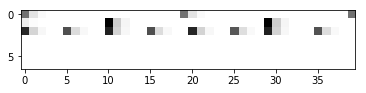

m (40, 7)


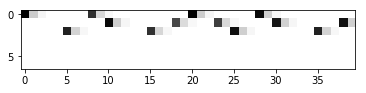

array(["../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid",
       '../datasets/drum_midi//50´s Drummer MIDI Files/06 Soul - Funk/08 Rim Soul 90BPM/01 4th Hat.mid'],
      dtype='<U106')

In [11]:
i = 0
j = 399
plot.single(x_train[i, :50,:,0])
plot.single(x_train[j, :50,:,0])
# plot.single(x_train[2, :50,:,0])
np.array(labels)[[i,j]]

In [12]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(40, 7, 1)

In [13]:
latent_dim = 5
epsilon_std = 1.0

In [14]:
def encoder(input_shape, dropout=0.1):
    encoder_input = Input(shape=input_shape)
    nodes = np.prod(input_shape)
    timesteps, notes, channels = input_shape
    
    # Convolution
    h = encoder_input
    k = (2,1)
    s = (2,1)
    
    h = Reshape((timesteps, notes))(h)
    h = Conv1D(64, kernel_size=2, strides=1, activation='relu', padding='valid')(h)
    
    h = Bidirectional(LSTM(128))(h)

    # Z Mean, Variance
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'
        
    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
#     print('Extra params:', [k.count_params() for k in [rnn, reshape, capsule]])

    return encoder_model, encoder_input, z_mean, z_log_var

In [15]:
encoder_model, encoder_input, z_mean, z_log_var = encoder(input_shape)
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40, 7, 1)     0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 40, 7)        0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 39, 64)       960         reshape_1[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 256)          197632      conv1d_1[0][0]                   
__________________________________________________________________________________________________
z_mean (De

In [16]:
sample_ = lambda args: models.sample(args, z_mean, z_log_var, latent_dim, epsilon_std)

In [17]:
# z = Lambda(sampling)([z_mean, z_log_var])
z_input = encoder_model(encoder_input)
z_output = Lambda(sample_)(z_input)
# z_output = Lambda(sampl_, output_shape=(latent_dim,))(encoder_input)

In [18]:
def list_decoders(output_shape):
    # decoder_input = z_output
    # h = decoder_input
    # :output_shape = (timesteps, channels, channels) || (batches, filters, timesteps, channels)
    # keras offers just Conv2DTranspose and not Conv1DTranspose
    # - use 2D images during upsampling :: (timesteps, notes, channels) => (timesteps, notes, filters)
    # - use 1D images to optimize reconstruction :: (timesteps, filters) => (timesteps, notes)
    
    # image_data_format = 'channels_last'
    # goal shape: (timesteps, notes, channels)
    # start with the 'reverse': lots of small imgs => few large img
    
    timesteps, notes, channels = output_shape

    # keras.examples.variational_autoencoder_deconv.py
    decoders = []
    decoders += [ Dense(256) ]
    decoders += [ LeakyReLU(alpha=0.3) ]
    
    # add a bypass layer
    w = 256
    decoders += [ Dense(w, activation='relu') ]
    extra_decoders = []
    for _ in range(3):
        extra_decoders += [ Dense(w, activation='elu', bias_initializer='zeros') ]

    extra_d = Lambda(lambda layer: utils.composition(extra_decoders, layer))
    decoders += [ Lambda(lambda layer: Add()([layer, extra_d(layer)])) ]
    
    decoders += [ BatchNormalization(momentum=0.9) ]
    n = 5
    # n+2: add extra embeddings at the start and the end
    decoders += [ RepeatVector(n+2) ]
    conductor_dims = 80 # 128
    decoders += [ Bidirectional(LSTM(conductor_dims, return_sequences=True)) ]
#     decoders += [ BatchNormalization(momentum=0.9, axis=1) ]

    #     decoders += [ TimeDistributed(x) ]
#     decoders += [ TimeDistributed(x) ]

    # Embedding decoder
    
    embedding_len = int(timesteps / n)
    embedding_size = int(2*conductor_dims / embedding_len) # 16
    print('embedding_len: %i, embedding_size: %i' % (embedding_len, embedding_size))
#     filters = 250
#     decoders += [ TimeDistributed(Dense(filters, activation='relu')) ]
    decoders += [ Reshape((n+2, embedding_len, embedding_size)) ] # (5, 8, 32)
    
    embedding_selectors = []
    for i in range(n):
        # Select 3 embeddings per layer
        # Note that the second index (j) is right-oriented (css style)
        j = n - i - 1
        print('embedding# %i:' %i,n+2, i, j, n+2 - i - j)
        embedding_selectors += [ Cropping2D([(i,j),(0,0)]) ]
        
    print(len(embedding_selectors))   
    # reshape: [x1,x2] -> [ concat[x1,x1] ] :: (2,x) -> (1, 2*x)
    reshape_e = Reshape((1, 3*embedding_len, embedding_size))
    
    # \layer -> map (\f -> f layer) [f1, f2, f3]
    split_embeddings = Lambda(lambda layer: list(map(lambda f: reshape_e(f(layer)), embedding_selectors)))
    decoders += [ split_embeddings ]
    decoders += [ Concatenate(axis=1) ]
    
    embedding_dims = 64
    x1 = Bidirectional(LSTM(embedding_dims, return_sequences=True)) # (embedding_len, embedding_dims)
    x2 = Cropping1D( (embedding_len, embedding_len) )
    x = Lambda(lambda layer: x2(x1(layer)) )
    decoders += [ TimeDistributed(x) ]
    # merge embeddings
    decoders += [ Reshape((n*embedding_len, 2*embedding_dims)) ]
    # final sigmoid layer
    decoders += [ TimeDistributed(Dense(notes, activation='sigmoid')) ]
    decoders += [ Reshape((timesteps, notes, 1)) ]

    return decoders

In [19]:
decoders = list_decoders(input_shape)

embedding_len: 8, embedding_size: 20
embedding# 0: 7 0 4 3
embedding# 1: 7 1 3 3
embedding# 2: 7 2 2 3
embedding# 3: 7 3 1 3
embedding# 4: 7 4 0 3
5


In [20]:
decoded = utils.composition(decoders, z_output, verbose=False)
# layer1, = layers

In [21]:
# layer1.output

In [22]:
# instantiate VAE model
vae_input = encoder_input
vae_output = decoded
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40, 7, 1)     0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 5), (None, 5 201162      input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 5)            0           encoder_model-[1][0]             
                                                                 encoder_model-[1][1]             
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          1536        lambda_2[0][0]                   
__________

In [23]:
# Compute VAE loss
def vae_loss(beta=1.):
#     beta = ((1.0 - tf.pow(hparams.beta_rate, tf.to_float(self.global_step)))
#             * hparams.max_beta)
#     self.loss = tf.reduce_mean(r_loss) + beta * tf.reduce_mean(kl_cost)
    # y_true, y_pred, z_mean, z_log_var, timesteps=150, notes=3, beta=1.
    xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(vae_input), K.flatten(vae_output))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    # kl_loss = max(kl_loss, free_bits)
    mse = K.mean(keras.losses.mean_absolute_error(vae_input, vae_output))
    vae_loss = K.mean(xent_loss + beta * kl_loss + 0.2 * mse)
    return vae_loss

vae_loss = vae_loss(beta=0.5)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
# vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Output "reshape_5" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_5" during training.
  app.launch_new_instance()


In [24]:
K.int_shape(z_mean)

(None, 5)

In [49]:
batch_size = 50
epochs = 500
params = {'batch_size': batch_size, 'return_y': False}

In [50]:
phase_mod = 0.01
whitening = False

In [51]:
m = 10
useDataGenerator = False
# useDataGenerator = True

x = x_train[:m]
x = x_train
i = [0,1, 7,8, 14,15, 399,400]
x = x_train[i]
x = np.concatenate([x for _ in range(10)])
print('x:', x.shape)

print('batch_size: %i' % batch_size)
print('update-iterations:', round(epochs * x.shape[0] / batch_size))
if useDataGenerator:
    datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
    history = collections.defaultdict(list)
    n_batches = datagen.__len__()
    for e in range(epochs):
        print('\n[Epoch %i/%i] >>>>>>>>>' % (e, epochs))
        for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x, x, batch_size)):
            print(' Batch %i/%i' % (batch_i,n_batches))
            x_ = x_batch
            # x_ = datagen.shuffle_3rd_dim(x_)
            # x_ = datagen.shuffle_3rd_dim_soft(x_, rate=0.5, scale=0.1, verbose=0)
            h = vae.fit(x_, validation_data=(x_test, None), verbose=0)
            for k,v in h.history.items(): 
                print(' \\_%s' % k, [round(v_,) for v_ in v])
                history[k].append(v)
            if batch_i >= n_batches:
                break
else:
    h = vae.fit(x, epochs=epochs, validation_data=(x_test, None))
    history = h.history

x: (80, 40, 7, 1)
batch_size: 50
update-iterations: 800
Train on 80 samples, validate on 50 samples
Epoch 1/500
80/80 [==============================] - 0s 6ms/step - loss: 30.8034 - val_loss: 49.2494
Epoch 2/500
80/80 [==============================] - 0s 6ms/step - loss: 30.7468 - val_loss: 49.0625
Epoch 3/500
80/80 [==============================] - 0s 6ms/step - loss: 30.6611 - val_loss: 49.1304
Epoch 4/500
80/80 [==============================] - 1s 6ms/step - loss: 30.6681 - val_loss: 49.3358
Epoch 5/500
80/80 [==============================] - 1s 7ms/step - loss: 30.6156 - val_loss: 48.9448
Epoch 6/500
80/80 [==============================] - 1s 7ms/step - loss: 30.7010 - val_loss: 48.6938
Epoch 7/500
80/80 [==============================] - 0s 6ms/step - loss: 30.4721 - val_loss: 49.3383
Epoch 8/500
80/80 [==============================] - 1s 7ms/step - loss: 30.6758 - val_loss: 48.9557
Epoch 9/500
80/80 [==============================] - 1s 7ms/step - loss: 30.7771 - val_loss:

80/80 [==============================] - 0s 6ms/step - loss: 27.9711 - val_loss: 49.5107
Epoch 81/500
80/80 [==============================] - 0s 6ms/step - loss: 27.9527 - val_loss: 49.1052
Epoch 82/500
80/80 [==============================] - 0s 6ms/step - loss: 27.8592 - val_loss: 49.2880
Epoch 83/500
80/80 [==============================] - 0s 6ms/step - loss: 27.9393 - val_loss: 49.1436
Epoch 84/500
80/80 [==============================] - 0s 6ms/step - loss: 27.9561 - val_loss: 49.6017
Epoch 85/500
80/80 [==============================] - 0s 6ms/step - loss: 27.8898 - val_loss: 49.3357
Epoch 86/500
80/80 [==============================] - 0s 6ms/step - loss: 27.7285 - val_loss: 48.9593
Epoch 87/500
80/80 [==============================] - 0s 6ms/step - loss: 27.8680 - val_loss: 49.7666
Epoch 88/500
80/80 [==============================] - 0s 6ms/step - loss: 27.7943 - val_loss: 49.5614
Epoch 89/500
80/80 [==============================] - 0s 6ms/step - loss: 27.6156 - val_loss: 4

Epoch 160/500
80/80 [==============================] - 1s 7ms/step - loss: 26.3326 - val_loss: 49.3661
Epoch 161/500
80/80 [==============================] - 1s 7ms/step - loss: 26.0606 - val_loss: 49.5611
Epoch 162/500
80/80 [==============================] - 1s 7ms/step - loss: 26.0641 - val_loss: 49.5758
Epoch 163/500
80/80 [==============================] - 1s 6ms/step - loss: 26.1526 - val_loss: 49.7618
Epoch 164/500
80/80 [==============================] - 0s 6ms/step - loss: 26.0912 - val_loss: 49.7298
Epoch 165/500
80/80 [==============================] - 0s 6ms/step - loss: 26.0182 - val_loss: 49.7056
Epoch 166/500
80/80 [==============================] - 0s 6ms/step - loss: 26.0178 - val_loss: 49.8013
Epoch 167/500
80/80 [==============================] - 0s 6ms/step - loss: 25.7380 - val_loss: 50.1194
Epoch 168/500
80/80 [==============================] - 0s 6ms/step - loss: 25.8236 - val_loss: 50.3704
Epoch 169/500
80/80 [==============================] - 1s 7ms/step - loss

80/80 [==============================] - 1s 6ms/step - loss: 23.9428 - val_loss: 51.2316
Epoch 240/500
80/80 [==============================] - 1s 7ms/step - loss: 23.6942 - val_loss: 51.2826
Epoch 241/500
80/80 [==============================] - 0s 6ms/step - loss: 23.6359 - val_loss: 51.5436
Epoch 242/500
80/80 [==============================] - 0s 6ms/step - loss: 23.6648 - val_loss: 51.3123
Epoch 243/500
80/80 [==============================] - 0s 6ms/step - loss: 23.7533 - val_loss: 51.3310
Epoch 244/500
80/80 [==============================] - 0s 6ms/step - loss: 23.6078 - val_loss: 51.3346
Epoch 245/500
80/80 [==============================] - 0s 6ms/step - loss: 23.6237 - val_loss: 51.3085
Epoch 246/500
80/80 [==============================] - 0s 6ms/step - loss: 23.5336 - val_loss: 51.5825
Epoch 247/500
80/80 [==============================] - 0s 6ms/step - loss: 23.6341 - val_loss: 51.6753
Epoch 248/500
80/80 [==============================] - 0s 6ms/step - loss: 23.5502 - va

80/80 [==============================] - 0s 6ms/step - loss: 22.0096 - val_loss: 53.3433
Epoch 319/500
80/80 [==============================] - 0s 6ms/step - loss: 22.0262 - val_loss: 53.3788
Epoch 320/500
80/80 [==============================] - 0s 6ms/step - loss: 22.0430 - val_loss: 53.4309
Epoch 321/500
80/80 [==============================] - 0s 6ms/step - loss: 22.2259 - val_loss: 52.7466
Epoch 322/500
80/80 [==============================] - 0s 6ms/step - loss: 22.0361 - val_loss: 52.2868
Epoch 323/500
80/80 [==============================] - 0s 6ms/step - loss: 22.0423 - val_loss: 52.2468
Epoch 324/500
80/80 [==============================] - 0s 6ms/step - loss: 22.1533 - val_loss: 53.4932
Epoch 325/500
80/80 [==============================] - 1s 6ms/step - loss: 22.0256 - val_loss: 54.0011
Epoch 326/500
80/80 [==============================] - 0s 6ms/step - loss: 22.0694 - val_loss: 54.0355
Epoch 327/500
80/80 [==============================] - 0s 6ms/step - loss: 21.9818 - va

80/80 [==============================] - 0s 6ms/step - loss: 20.6796 - val_loss: 54.6946
Epoch 398/500
80/80 [==============================] - 0s 6ms/step - loss: 20.4914 - val_loss: 54.7468
Epoch 399/500
80/80 [==============================] - 0s 6ms/step - loss: 20.5228 - val_loss: 55.6958
Epoch 400/500
80/80 [==============================] - 0s 6ms/step - loss: 20.5497 - val_loss: 55.7089
Epoch 401/500
80/80 [==============================] - 0s 6ms/step - loss: 20.5101 - val_loss: 54.8501
Epoch 402/500
80/80 [==============================] - 0s 6ms/step - loss: 20.6164 - val_loss: 54.6844
Epoch 403/500
80/80 [==============================] - 0s 6ms/step - loss: 20.4374 - val_loss: 55.1304
Epoch 404/500
80/80 [==============================] - 0s 6ms/step - loss: 20.3901 - val_loss: 55.4460
Epoch 405/500
80/80 [==============================] - 0s 6ms/step - loss: 20.4688 - val_loss: 55.1771
Epoch 406/500
80/80 [==============================] - 0s 6ms/step - loss: 20.3640 - va

80/80 [==============================] - 0s 6ms/step - loss: 19.5124 - val_loss: 57.2502
Epoch 477/500
80/80 [==============================] - 0s 6ms/step - loss: 19.4444 - val_loss: 56.9102
Epoch 478/500
80/80 [==============================] - 0s 6ms/step - loss: 19.4900 - val_loss: 57.1360
Epoch 479/500
80/80 [==============================] - 0s 6ms/step - loss: 19.3822 - val_loss: 57.6201
Epoch 480/500
80/80 [==============================] - 0s 6ms/step - loss: 19.2971 - val_loss: 57.6075
Epoch 481/500
80/80 [==============================] - 0s 6ms/step - loss: 19.4190 - val_loss: 56.4236
Epoch 482/500
80/80 [==============================] - 0s 6ms/step - loss: 19.2917 - val_loss: 57.3680
Epoch 483/500
80/80 [==============================] - 0s 6ms/step - loss: 19.3579 - val_loss: 56.3499
Epoch 484/500
80/80 [==============================] - 0s 6ms/step - loss: 19.2771 - val_loss: 56.4126
Epoch 485/500
80/80 [==============================] - 0s 6ms/step - loss: 19.3112 - va

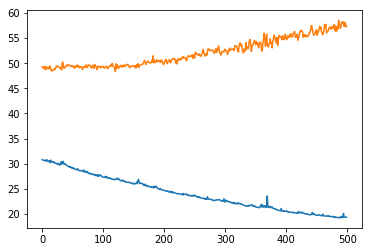

In [52]:
plt.plot(history['loss'][0:])
plt.plot(history['val_loss'][0:])

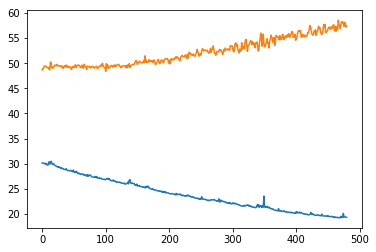

In [53]:
start = 20
plt.plot(history['loss'][start:])
plt.plot(history['val_loss'][start:])

In [54]:
x.shape

(80, 40, 7, 1)

m (40, 7, 1)


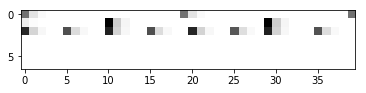

m (40, 7, 1)


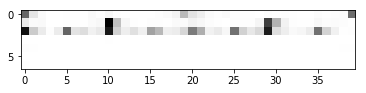

m (40, 7, 1)


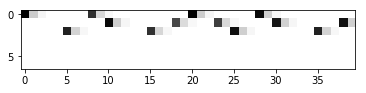

m (40, 7, 1)


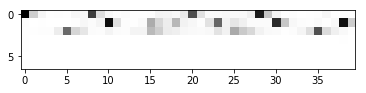

In [62]:
i = 0
j = 399
y = vae.predict(x_train[:500])
plot.single(x_train[i])
plot.single(y[i])
plot.single(x_train[j])
plot.single(y[j])

In [63]:
# x = datagen.shuffle_3rd_dim_soft(x_train[:10], rate=1, intensity=2, scale=1, verbose=1)
# i = 0
# plot.single(x_train[i,:,:,0])
# plot.single(x[i,:,:,0])
# x_ = vae.predict(x)
# plot.single(x_[i,:,:,0])

In [64]:
x.shape

(80, 40, 7, 1)

m (30, 7)


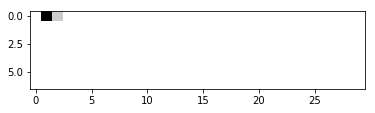

In [65]:
# min: these pixels are 'always' active
m = x.min(axis=0)
plot.multi(m[:30,:,0])

m (30, 7)


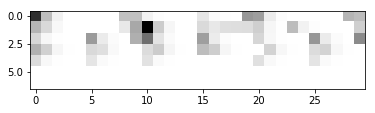

In [66]:
# mean
m = x.mean(axis=0)
plot.single(m[:30,:,0])

## Encoder + Decoder (generator)
A model to project inputs on the latent space

In [67]:
# build a model to project inputs on the latent space
encoder = Model(encoder_input, z_mean)

In [68]:
decoder_input = Input((latent_dim,))
decoded = utils.composition(decoders, decoder_input)
decoder = Model(decoder_input, decoded)

In [69]:
x_test.shape

(50, 40, 7, 1)

In [70]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(100, 5)

(6, 40, 7, 1) [ 0.00320002  0.01055091 -0.0070183   1.3716475  -0.01410014]
m (40, 7, 1)


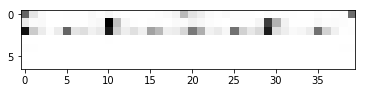

m (40, 7, 1)


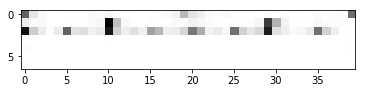

m (40, 7, 1)


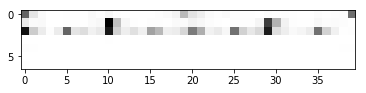

m (40, 7, 1)


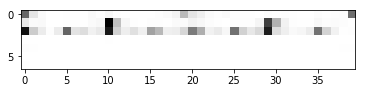

m (40, 7, 1)


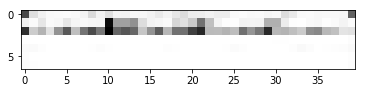

In [71]:
i = 0
amt = 1
z = encoder.predict(x_train[i:i+1])
zs = [ z[0].copy() for _ in range(latent_dim) ]
for i,z_ in enumerate(zs):
    z_[i] = z_[i] + amt
generated = decoder.predict(np.concatenate([z[:1], zs]))
print(generated.shape, z[0,:5])
plot.single(generated[0])
plot.single(generated[1])
plot.single(generated[2])
plot.single(generated[3])
plot.single(generated[4])

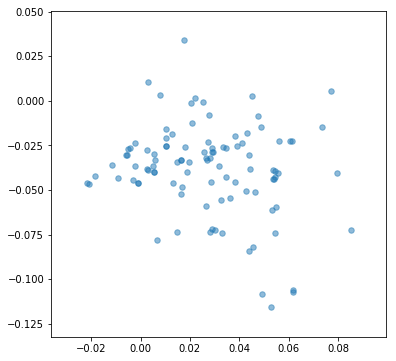

In [72]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], alpha=0.5, s=30) # c=y_test, 

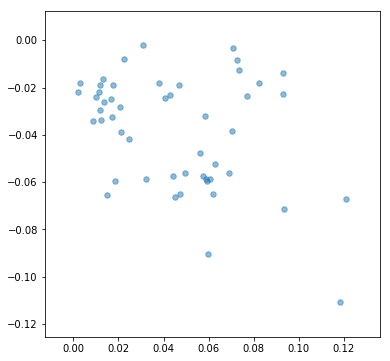

In [73]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], alpha=0.5, s=30) # , c=y_test
# plt.colorbar()

In [74]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_decoded = utils.composition(decoders, decoder_input, verbose=False)
generator = Model(decoder_input, _decoded)

In [75]:
# x_decoded[0].reshape(150,3)

In [76]:
x_train.shape

(450, 40, 7, 1)

(5,) [0.5 0.5 0.5 0.5 0.5]


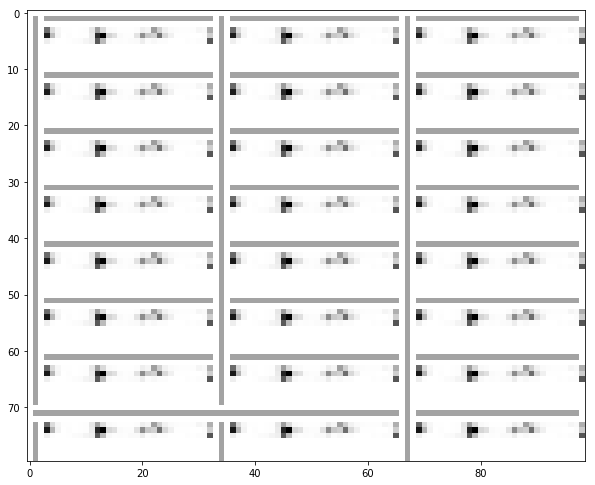

In [81]:
min_y = 0.01
max_y = 0.5
plot.latent(generator, batch_size, latent_dim,
       x_encoded=0.5,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y,
       max_y=max_y)

(5,) [0.5 0.5 0.5 0.5 0.5]


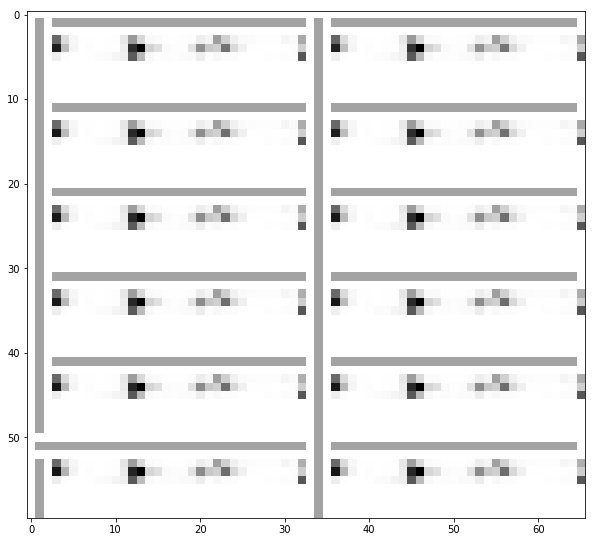

In [78]:
min_y2 = max_y
plot.latent(generator, batch_size, latent_dim,
       x_encoded=0.5,            
       n=6,
       m=2,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y2,
       max_y=0.95)

In [79]:
a = [0,11,100,399]
# utils.clear_dir(config.export_dir)
for i in a:
    s = midi.MultiTrack.from_array(x_train[i])
    mid = midi.decode.track(context, s, transpose=0)
    io.export_midifile(mid, config.export_dir + 'y_true_' + str(i))
    
    s = midi.MultiTrack.from_array(y[i])
    mid = midi.decode.track(context, s, transpose=0)
    io.export_midifile(mid, config.export_dir + 'y_pred' + str(i))    

 [INFO] : 
 |  len, max_t
 |  1.9802083333333331
 |  2.0
 [INFO] : 
 |  len, max_t
 |  1.9802083333333331
 |  2.0
 [INFO] : 
 |  len, max_t
 |  1.8802083333333333
 |  2.0
 [INFO] : 
 |  len, max_t
 |  1.7802083333333334
 |  2.0
 [INFO] : 
 |  len, max_t
 |  1.8802083333333335
 |  2.0
 [INFO] : 
 |  len, max_t
 |  1.7802083333333334
 |  2.0
 [INFO] : 
 |  len, max_t
 |  1.9302083333333337
 |  2.0
 [INFO] : 
 |  len, max_t
 |  1.930208333333334
 |  2.0
